# Linear Regression Naive

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("airline_ticket_dataset.csv")

data = pd.read_csv(DATA_PATH)
print(f"Shape: {data.shape}")
data.describe()


Shape: (14004, 21)


,Year,quarter,citymarketid_1,citymarketid_2,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
count,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,1.399700e+04,13997.000000,13997.000000,1.397900e+04,13979.000000,13979.000000
mean,2023.285633,2.357112,31506.638889,32300.714296,1061.839617,1024.581762,237.699035,0.566322,245.713270,0.327737,180.954832,3.220308e+06,0.836383,-0.007360,2.955601e+06,0.832683,-0.038586
std,1.030128,1.108776,1214.185463,1421.194815,589.956663,1475.981346,63.929831,0.174240,77.518173,0.228027,69.241252,2.319576e+06,0.141082,0.108333,2.014224e+06,0.142587,0.119825
min,2022.000000,1.000000,30135.000000,30189.000000,129.000000,163.000000,76.770000,0.209700,76.770000,0.010000,66.160000,2.993000e+04,0.000000,-0.619400,5.464000e+04,0.000000,-0.641100
25%,2022.000000,1.000000,30529.000000,30852.000000,604.000000,316.000000,193.087500,0.431800,193.357500,0.154500,119.590000,1.224800e+06,0.793600,-0.051600,1.582850e+06,0.788400,-0.077500
50%,2023.000000,2.000000,31057.000000,32211.000000,936.000000,526.000000,227.640000,0.541600,239.245000,0.265550,175.215000,2.873210e+06,0.865900,-0.003200,2.764620e+06,0.863200,-0.022700
75%,2024.000000,3.000000,32244.000000,33342.000000,1404.000000,1086.250000,275.615000,0.676725,293.952500,0.444300,225.875000,4.254110e+06,0.922500,0.048400,3.661990e+06,0.939300,0.040500
max,2025.000000,4.000000,35412.000000,35628.000000,2724.000000,21058.000000,676.890000,1.000000,679.120000,1.000000,669.740000,8.840080e+06,1.000000,0.965900,8.840080e+06,1.000000,0.350800


## Visualizing QQPlot 

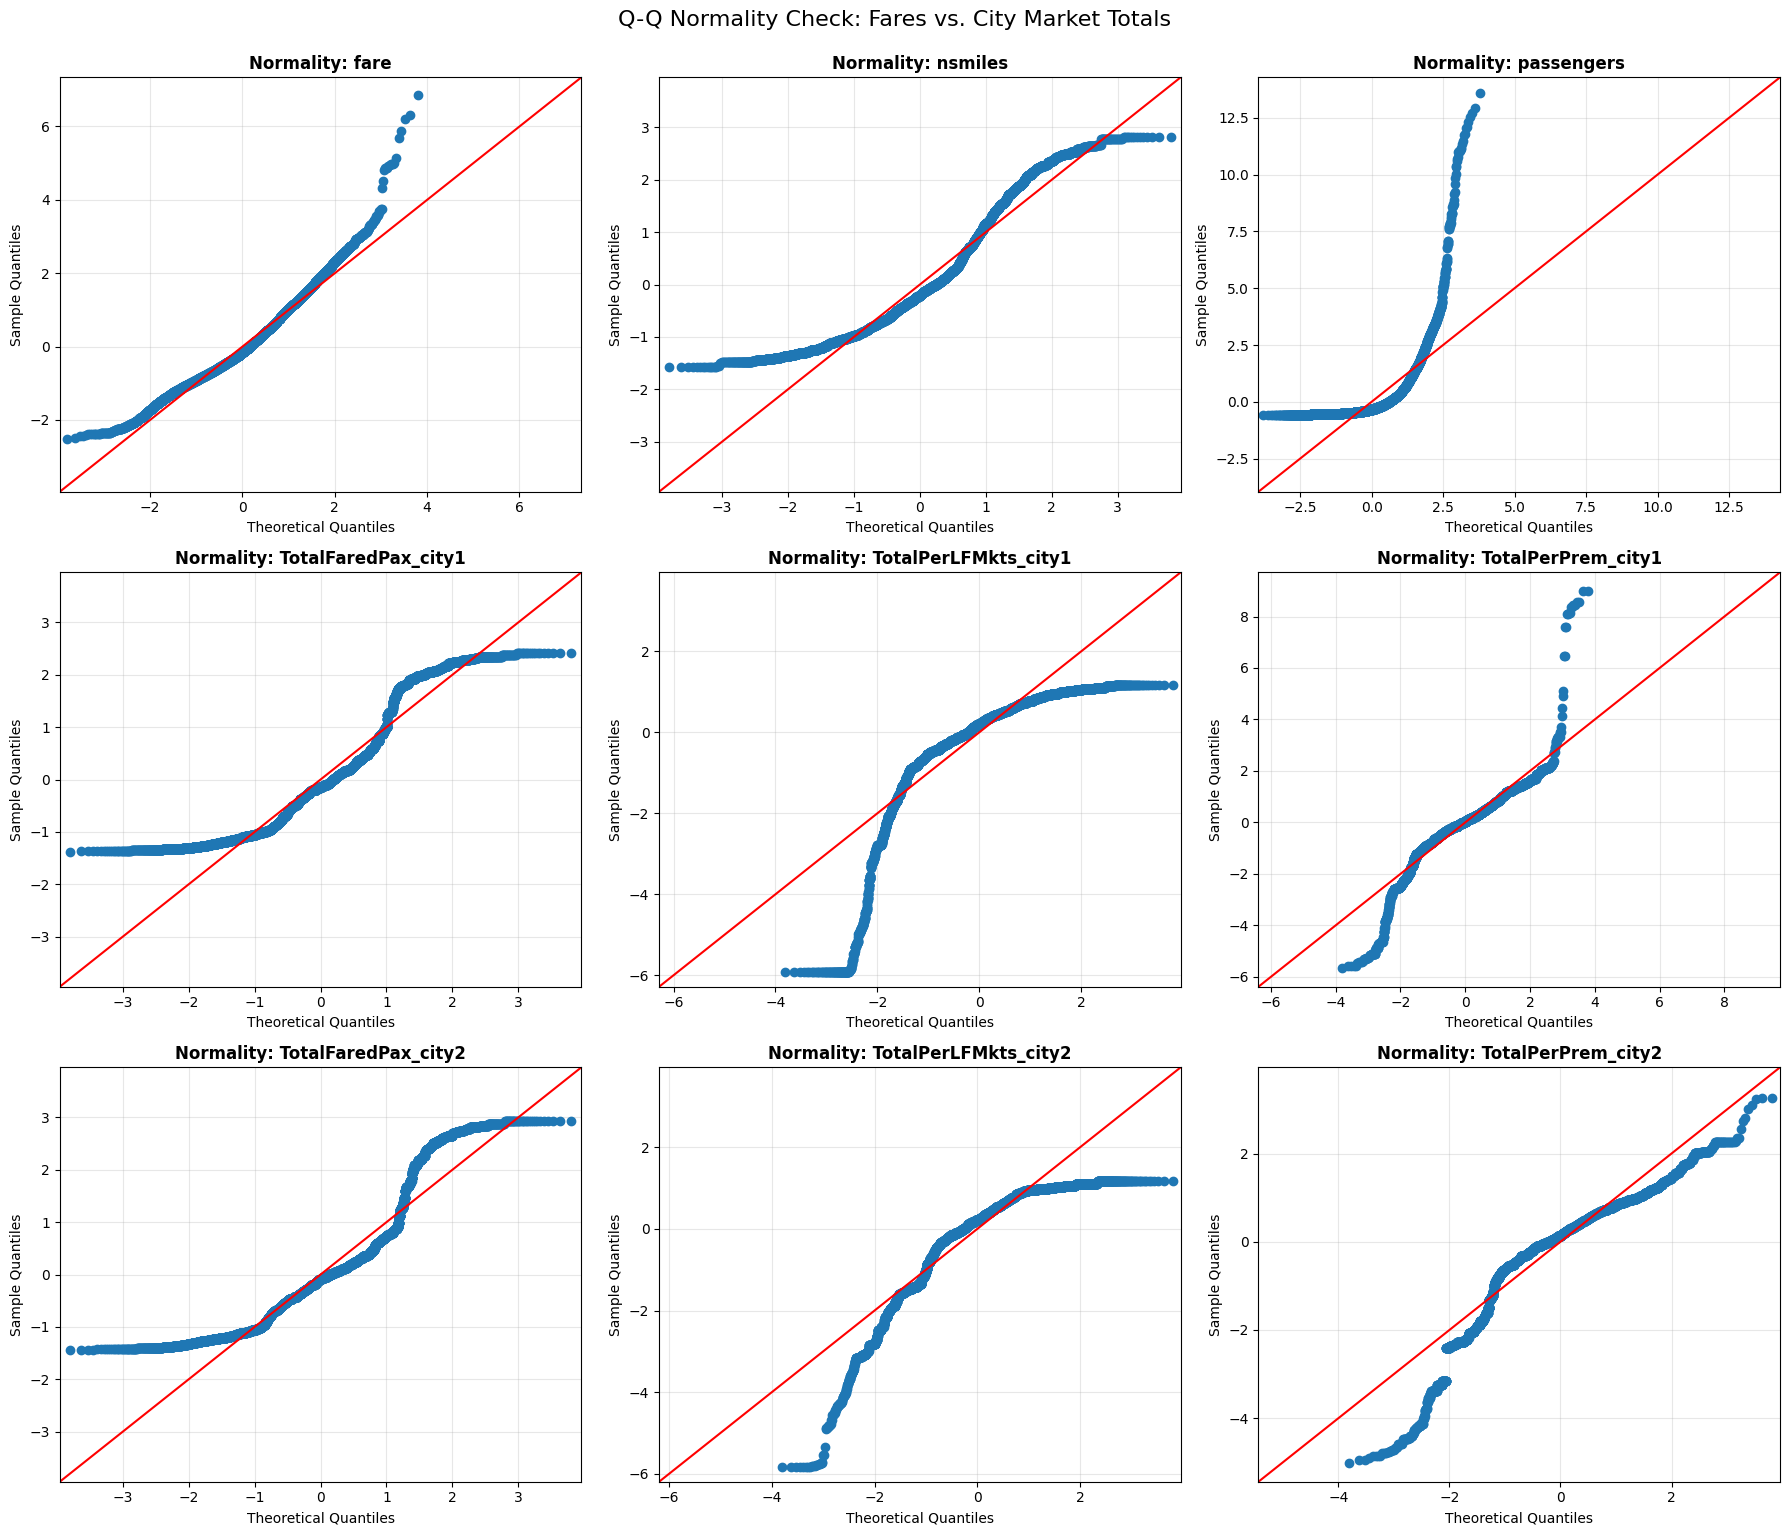

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

cols_to_check = [
    'fare', 'nsmiles', 'passengers', 
    'TotalFaredPax_city1', 'TotalPerLFMkts_city1', 'TotalPerPrem_city1',
    'TotalFaredPax_city2', 'TotalPerLFMkts_city2', 'TotalPerPrem_city2'
]

# Create a 3x3 grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cols_to_check):
    if col in data.columns:
        # Drop NaNs and ensure data is numeric
        clean_data = pd.to_numeric(data[col], errors='coerce').dropna()
        
        # Plotting with the 45-degree reference line
        sm.qqplot(clean_data, line='45', fit=True, ax=axes[i])
        
        axes[i].set_title(f'Normality: {col}', fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
    else:
        # Hide the subplot if the column name doesn't exist
        axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Q-Q Normality Check: Fares vs. City Market Totals', fontsize=16, y=1.02)
plt.show()

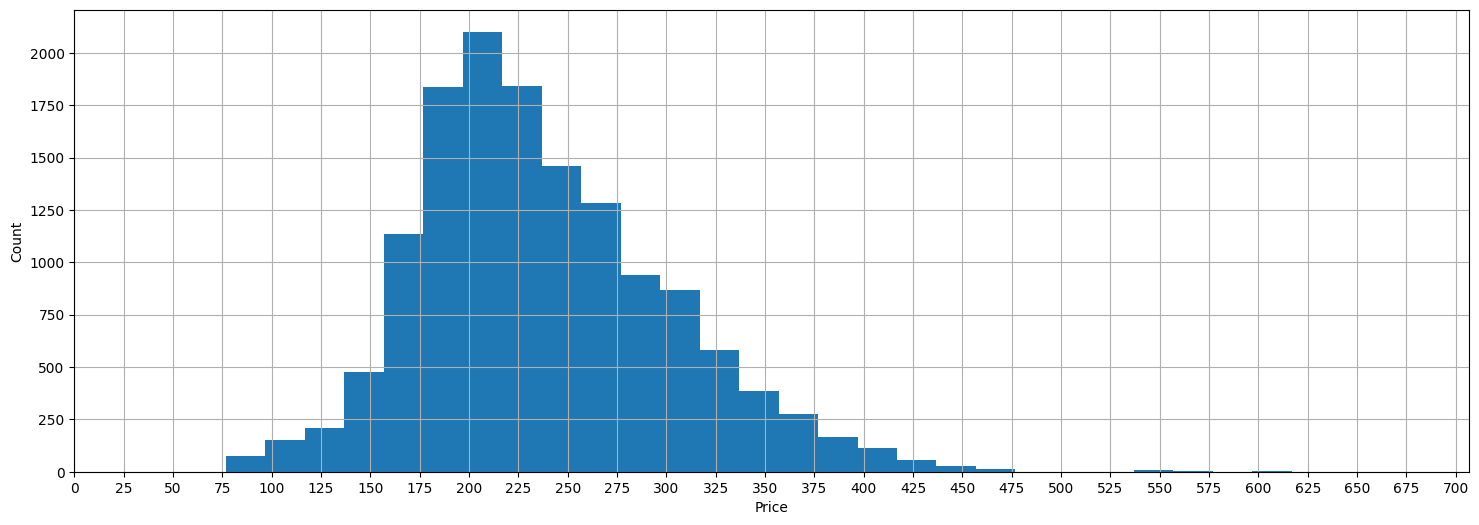

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))
data['fare'].hist(ax=ax, bins=30)

xmin, xmax = ax.get_xlim()
ax.set_xticks(np.arange(0, xmax, 25))

plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

## Clean Data

In [19]:
# Combine first
model_df = data[['Year', 'quarter', 'fare', 'nsmiles', 'passengers',
                 'large_ms', 'fare_lg', 'lf_ms', 'fare_low',
                 'TotalFaredPax_city1', 'TotalPerLFMkts_city1', 'TotalPerPrem_city1',
                 'TotalFaredPax_city2', 'TotalPerLFMkts_city2', 'TotalPerPrem_city2']].copy()

# Convert to numeric
model_df = model_df.apply(pd.to_numeric, errors='coerce')

# Drop inf
model_df = model_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with any missing values
model_df = model_df.dropna()

## Setting up targets and features

We tackle this by introducing feature engineering, adding columns to the dataframe for better feedback

### Feature Engineering 

In [20]:
# Engineered features
model_df['ms_diff'] = model_df['large_ms'] - model_df['lf_ms']
model_df['demand_density'] = model_df['passengers'] / model_df['nsmiles']
model_df['total_fared_pax'] = model_df['TotalFaredPax_city1'] + model_df['TotalFaredPax_city2']
model_df['pax_asymmetry'] = model_df['TotalFaredPax_city1'] / model_df['TotalFaredPax_city2']

## Quarter Sequence Mapping — Q1 to Q14

The dataset spans 14 consecutive quarters. We number them Q1–Q14 to reason about time-ordered splits:

| Seq | Year | Quarter |
|-----|------|---------|
| Q1–Q4 | 2022 | 1–4 |
| Q5–Q8 | 2023 | 1–4 |
| Q9–Q12 | 2024 | 1–4 |
| Q13–Q14 | 2025 | 1–2 |


In [21]:
# Build quarter_seq: chronological integer 1..14
quarter_map = {
    (2022, 1): 1,  (2022, 2): 2,  (2022, 3): 3,  (2022, 4): 4,
    (2023, 1): 5,  (2023, 2): 6,  (2023, 3): 7,  (2023, 4): 8,
    (2024, 1): 9,  (2024, 2): 10, (2024, 3): 11, (2024, 4): 12,
    (2025, 1): 13, (2025, 2): 14,
}
model_df["quarter_seq"] = model_df.apply(
    lambda r: quarter_map.get((int(r["Year"]), int(r["quarter"])), np.nan), axis=1
)

print("Rows per quarter_seq:")
print(model_df.groupby("quarter_seq").size().to_frame("rows").T.to_string())
print(f"\nTotal rows: {len(model_df):,}  |  Unique seq values: {sorted(model_df['quarter_seq'].unique())}")


Rows per quarter_seq:
quarter_seq   1    2    3    4    5     6    7    8    9    10   11   12   13   14
rows         996  999  998  998  997  1000  999  998  995  999  998  998  999  998

Total rows: 13,972  |  Unique seq values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]


In [22]:
FEATURES = [
    'nsmiles', 'passengers', 'large_ms', 'lf_ms',
    'ms_diff', 'demand_density', 'total_fared_pax', 'pax_asymmetry',
    'TotalPerLFMkts_city1', 'TotalPerLFMkts_city2',
    'TotalPerPrem_city1', 'TotalPerPrem_city2',
    'quarter',
]
TARGET = 'fare'

print(f"Features ({len(FEATURES)}): {FEATURES}")
print(f"Target: log1p({TARGET})")
print(f"\nAll features present: {all(f in model_df.columns for f in FEATURES)}")


Features (13): ['nsmiles', 'passengers', 'large_ms', 'lf_ms', 'ms_diff', 'demand_density', 'total_fared_pax', 'pax_asymmetry', 'TotalPerLFMkts_city1', 'TotalPerLFMkts_city2', 'TotalPerPrem_city1', 'TotalPerPrem_city2', 'quarter']
Target: log1p(fare)

All features present: True


## Rolling Walk-Forward Validation

We use a **walk-forward** (expanding window) scheme to respect the temporal order of the data:

| Fold | Train | Validate |
|------|-------|----------|
| 1 | Q1–Q6 (2022Q1–2023Q2) | Q7 (2023Q3) |
| 2 | Q1–Q7 (2022Q1–2023Q3) | Q8 (2023Q4) |
| 3 | Q1–Q8 (2022Q1–2023Q4) | Q9 (2024Q1) |
| 4 | Q1–Q9 (2022Q1–2024Q1) | Q10 (2024Q2) |

Final hold-out test: **Q11–Q14** (2024Q3–2025Q2), trained on full Q1–Q10.

Models evaluated: **Linear Regression**, **Ridge**, **HistGradientBoosting**, **Random Forest**, **XGBoost**, **ExtraTrees**.  
Metric: RMSE and R² in log-fare space, plus RMSE in dollar space.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (HistGradientBoostingRegressor,
                               RandomForestRegressor, ExtraTreesRegressor)
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# ── Model registry ────────────────────────────────────────────────────────────
def get_models():
    return {
        "LinearReg":  LinearRegression(),
        "Ridge":      Ridge(alpha=1.0),
        "HGB":        HistGradientBoostingRegressor(max_iter=300, random_state=42),
        "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=None,
                                              n_jobs=-1, random_state=42),
        "XGBoost":    XGBRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=5, random_state=42,
                                   verbosity=0, eval_metric="rmse"),
        "ExtraTrees": ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=42),
    }

# ── Rolling folds: (train_up_to, validate_seq) ───────────────────────────────
ROLLING_FOLDS = [
    (6,  7),   # Train Q1–Q6  → Val Q7
    (7,  8),   # Train Q1–Q7  → Val Q8
    (8,  9),   # Train Q1–Q8  → Val Q9
    (9,  10),  # Train Q1–Q9  → Val Q10
]

records = []

for train_end, val_seq in ROLLING_FOLDS:
    train_df = model_df[model_df["quarter_seq"] <= train_end]
    val_df   = model_df[model_df["quarter_seq"] == val_seq]

    X_tr = train_df[FEATURES].values
    y_tr = np.log1p(train_df[TARGET].values)
    X_va = val_df[FEATURES].values
    y_va = np.log1p(val_df[TARGET].values)
    y_va_dollar = val_df[TARGET].values

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)

    fold_label = f"Train Q1-Q{train_end} -> Val Q{val_seq}"
    print(f"\n{'-'*60}")
    print(f"  {fold_label}  |  train={len(train_df):,}  val={len(val_df):,}")
    print(f"{'-'*60}")

    for name, mdl in get_models().items():
        mdl.fit(X_tr_s, y_tr)
        y_pred_log = mdl.predict(X_va_s)

        rmse_log  = np.sqrt(mean_squared_error(y_va, y_pred_log))
        r2        = r2_score(y_va, y_pred_log)
        rmse_usd  = np.sqrt(mean_squared_error(y_va_dollar, np.expm1(y_pred_log)))

        print(f"  {name:<14}  RMSE(log)={rmse_log:.4f}  R2={r2:.4f}  RMSE($)={rmse_usd:.2f}")
        records.append({
            "fold": fold_label,
            "val_q": val_seq,
            "model": name,
            "rmse_log": round(rmse_log, 4),
            "r2": round(r2, 4),
            "rmse_usd": round(rmse_usd, 2),
        })

results_df = pd.DataFrame(records)
print("\n\nRolling validation complete.")


------------------------------------------------------------
  Train Q1-Q6 -> Val Q7  |  train=5,988  val=999
------------------------------------------------------------
  LinearReg       RMSE(log)=0.1544  R2=0.6548  RMSE($)=35.44
  Ridge           RMSE(log)=0.1544  R2=0.6549  RMSE($)=35.43
  HGB             RMSE(log)=0.1141  R2=0.8114  RMSE($)=27.56
  RandomForest    RMSE(log)=0.1165  R2=0.8035  RMSE($)=28.25
  XGBoost         RMSE(log)=0.1219  R2=0.7850  RMSE($)=29.20
  ExtraTrees      RMSE(log)=0.1101  R2=0.8246  RMSE($)=26.90

------------------------------------------------------------
  Train Q1-Q7 -> Val Q8  |  train=6,987  val=998
------------------------------------------------------------
  LinearReg       RMSE(log)=0.1364  R2=0.6888  RMSE($)=32.88
  Ridge           RMSE(log)=0.1364  R2=0.6888  RMSE($)=32.87
  HGB             RMSE(log)=0.0860  R2=0.8762  RMSE($)=21.24
  RandomForest    RMSE(log)=0.0891  R2=0.8673  RMSE($)=21.77
  XGBoost         RMSE(log)=0.0978  R2=0.8400 

=== RMSE ($) by Fold × Model ===
model  ExtraTrees    HGB  LinearReg  RandomForest  Ridge  XGBoost
val_q                                                            
7           26.90  27.56      35.44         28.25  35.43    29.20
8           20.36  21.24      32.88         21.77  32.87    24.20
9           25.84  27.70      36.36         27.65  36.36    28.70
10          22.48  25.12      31.11         23.69  31.11    26.01

=== R² by Fold × Model ===
model  ExtraTrees     HGB  LinearReg  RandomForest   Ridge  XGBoost
val_q                                                              
7          0.8246  0.8114     0.6548        0.8035  0.6549   0.7850
8          0.8880  0.8762     0.6888        0.8673  0.6888   0.8400
9          0.8471  0.8252     0.6608        0.8391  0.6608   0.8091
10         0.8638  0.8237     0.6976        0.8361  0.6976   0.8148

=== Mean RMSE($) across all folds (lower = better) ===
model
ExtraTrees      23.8950
RandomForest    25.3400
HGB             25.4050
X

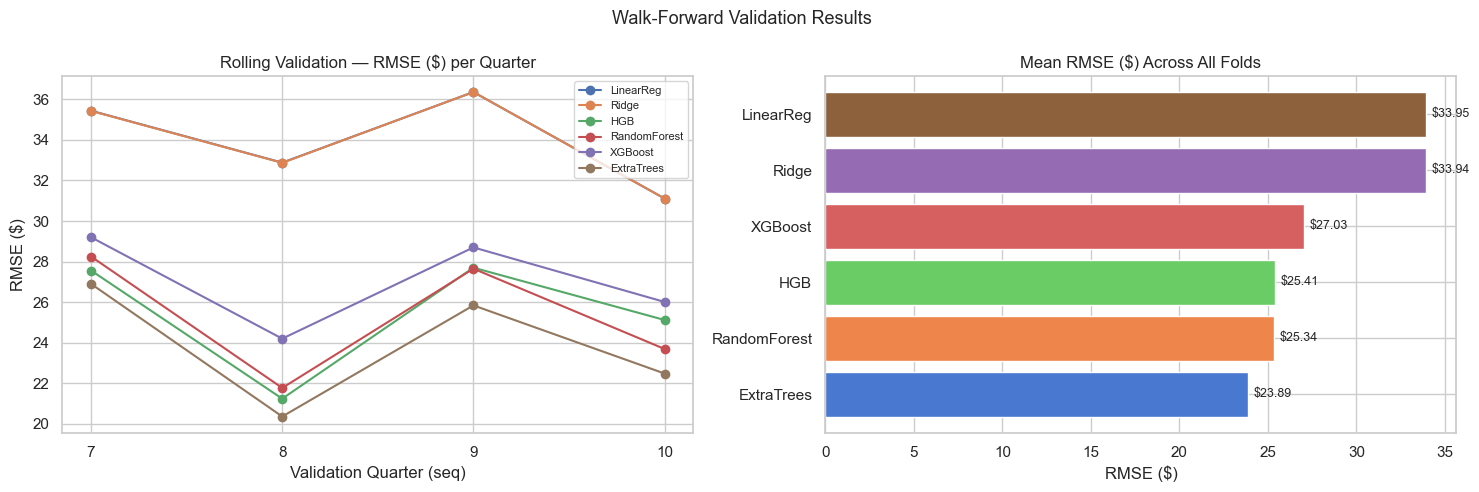

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# ── Summary pivot: avg RMSE($) per model across folds ─────────────────────────
pivot_rmse = results_df.pivot(index="val_q", columns="model", values="rmse_usd")
pivot_r2   = results_df.pivot(index="val_q", columns="model", values="r2")

print("=== RMSE ($) by Fold × Model ===")
print(pivot_rmse.to_string())
print("\n=== R² by Fold × Model ===")
print(pivot_r2.to_string())

mean_rmse = results_df.groupby("model")["rmse_usd"].mean().sort_values()
print("\n=== Mean RMSE($) across all folds (lower = better) ===")
print(mean_rmse.to_string())

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# (a) RMSE per fold
for model_name in results_df["model"].unique():
    sub = results_df[results_df["model"] == model_name].sort_values("val_q")
    axes[0].plot(sub["val_q"].astype(str), sub["rmse_usd"], marker="o", label=model_name)
axes[0].set_title("Rolling Validation — RMSE ($) per Quarter")
axes[0].set_xlabel("Validation Quarter (seq)")
axes[0].set_ylabel("RMSE ($)")
axes[0].legend(fontsize=8)

# (b) Mean RMSE bar chart
axes[1].barh(mean_rmse.index, mean_rmse.values,
             color=sns.color_palette("muted", len(mean_rmse)))
for i, v in enumerate(mean_rmse.values):
    axes[1].text(v + 0.3, i, f"${v:.2f}", va="center", fontsize=9)
axes[1].set_title("Mean RMSE ($) Across All Folds")
axes[1].set_xlabel("RMSE ($)")

plt.suptitle("Walk-Forward Validation Results", fontsize=13)
plt.tight_layout()
plt.show()


## Final Test — Q11 to Q14 (2024 Q3 → 2025 Q2)

Retrain all models on the full rolling window (Q1–Q10) and evaluate on the **held-out test set (Q11–Q14)**.  
This simulates how the model would perform on future data it has never seen.


In [25]:
train_final = model_df[model_df["quarter_seq"] <= 10]
test_final  = model_df[model_df["quarter_seq"] >= 11]

X_tr_f = train_final[FEATURES].values
y_tr_f = np.log1p(train_final[TARGET].values)
X_te_f = test_final[FEATURES].values
y_te_f = np.log1p(test_final[TARGET].values)
y_te_dollar = test_final[TARGET].values

scaler_final = StandardScaler()
X_tr_f_s = scaler_final.fit_transform(X_tr_f)
X_te_f_s = scaler_final.transform(X_te_f)

print(f"Train (Q1–Q10): {len(train_final):,} rows  |  Test (Q11–Q14): {len(test_final):,} rows\n")
print(f"{'Model':<16}  {'RMSE(log)':>10}  {'R²':>8}  {'RMSE($)':>10}")
print("─" * 50)

test_records = []
extratrees_final = None  # capture ExtraTrees for reuse in feature importance cell
for name, mdl in get_models().items():
    mdl.fit(X_tr_f_s, y_tr_f)
    if name == "ExtraTrees":
        extratrees_final = mdl          # reuse below — avoids retraining
    y_pred = mdl.predict(X_te_f_s)
    rmse_log = np.sqrt(mean_squared_error(y_te_f, y_pred))
    r2       = r2_score(y_te_f, y_pred)
    rmse_usd = np.sqrt(mean_squared_error(y_te_dollar, np.expm1(y_pred)))
    print(f"{name:<16}  {rmse_log:>10.4f}  {r2:>8.4f}  {rmse_usd:>10.2f}")
    test_records.append({"model": name, "rmse_log": rmse_log, "r2": r2, "rmse_usd": rmse_usd})

test_summary = pd.DataFrame(test_records).set_index("model").sort_values("rmse_usd")
print("\nBest model on test set:", test_summary["rmse_usd"].idxmin())


Train (Q1–Q10): 9,979 rows  |  Test (Q11–Q14): 3,993 rows

Model              RMSE(log)        R²     RMSE($)
──────────────────────────────────────────────────
LinearReg             0.1551    0.6023       36.72
Ridge                 0.1551    0.6023       36.72
HGB                   0.1121    0.7925       27.45
RandomForest          0.1129    0.7894       27.75
XGBoost               0.1196    0.7635       29.20
ExtraTrees            0.1103    0.7989       26.69

Best model on test set: ExtraTrees


## Feature Importance — OLS vs ExtraTrees

Compare **which features most strongly drive fare prices** using two complementary lenses:

- **OLS standardised β coefficients** — linear, interpretable direction (positive = raises fare, negative = lowers fare)  
- **ExtraTrees permutation importance** — nonlinear, model-agnostic; measures mean drop in test R² when a feature is randomly shuffled

Both are evaluated on the **held-out test set (Q11–Q14)** trained on Q1–Q10, matching the final test above.


=== OLS Standardised Coefficients ===
Train R²=0.7186   Test R²=0.6023
                  Feature      Beta             p
           Route distance  0.194610  0.000000e+00
Hub premium index @ city1  0.089069  0.000000e+00
Hub premium index @ city2  0.084255  0.000000e+00
   Total fared passengers -0.024570  8.617909e-47
        Market share diff  0.021290 3.630579e-119
          Quarter of year  0.018702  1.259380e-36
         LCC market share -0.017042  8.163653e-59
         Passenger volume -0.016843  1.581809e-10
      Passenger asymmetry -0.016298  4.917204e-24
Demand density (pax/mile) -0.008380  1.469852e-03
    Largest carrier share  0.007316  7.658029e-09
  LCC penetration @ city1  0.006819  7.636533e-05
  LCC penetration @ city2  0.004337  1.298097e-02

=== ExtraTrees Permutation Importance (Test R²=0.7989) ===
                  Feature  Importance      Std
           Route distance    1.125756 0.037948
Hub premium index @ city2    0.183357 0.006010
Hub premium index @ city1   

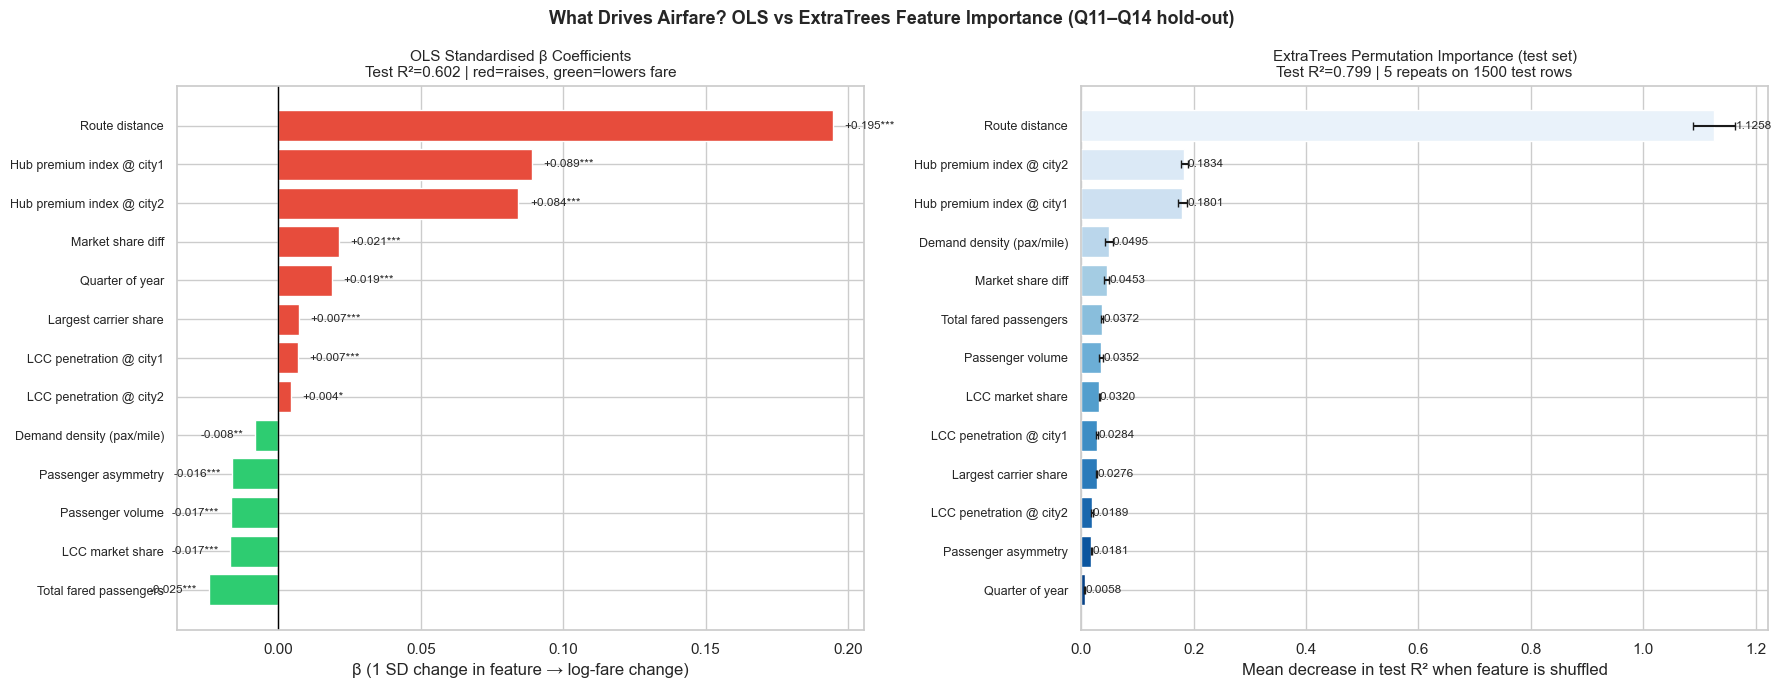


=== Feature ranking comparison ===
                           OLS rank  ExtraTrees rank  Avg rank
Feature                                                       
Route distance                  1.0              1.0       1.0
Hub premium index @ city2       3.0              2.0       2.5
Hub premium index @ city1       2.0              3.0       2.5
Demand density (pax/mile)      10.0              4.0       7.0
Market share diff               5.0              5.0       5.0
Total fared passengers          4.0              6.0       5.0
Passenger volume                8.0              7.0       7.5
LCC market share                7.0              8.0       7.5
LCC penetration @ city1        12.0              9.0      10.5
Largest carrier share          11.0             10.0      10.5
LCC penetration @ city2        13.0             11.0      12.0
Passenger asymmetry             9.0             12.0      10.5
Quarter of year                 6.0             13.0       9.5


In [26]:
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

# ── Feature labels for display ────────────────────────────────────────────────
FEATURE_LABELS = {
    'nsmiles':              'Route distance',
    'passengers':           'Passenger volume',
    'large_ms':             'Largest carrier share',
    'lf_ms':                'LCC market share',
    'ms_diff':              'Market share diff',
    'demand_density':       'Demand density (pax/mile)',
    'total_fared_pax':      'Total fared passengers',
    'pax_asymmetry':        'Passenger asymmetry',
    'TotalPerLFMkts_city1': 'LCC penetration @ city1',
    'TotalPerLFMkts_city2': 'LCC penetration @ city2',
    'TotalPerPrem_city1':   'Hub premium index @ city1',
    'TotalPerPrem_city2':   'Hub premium index @ city2',
    'quarter':              'Quarter of year',
}
labels = [FEATURE_LABELS[f] for f in FEATURES]

# ── OLS on the final train/test split ────────────────────────────────────────
ols = sm.OLS(y_tr_f, sm.add_constant(X_tr_f_s)).fit()
ols_r2_test = r2_score(y_te_f, ols.predict(sm.add_constant(X_te_f_s)))

coef_df = pd.DataFrame({
    'Feature': labels,
    'Beta':    ols.params[1:],
    'p':       ols.pvalues[1:],
})
coef_df['|Beta|'] = coef_df['Beta'].abs()
coef_df = coef_df.sort_values('|Beta|', ascending=False)

print('=== OLS Standardised Coefficients ===')
print(f'Train R²={ols.rsquared:.4f}   Test R²={ols_r2_test:.4f}')
print(coef_df[['Feature', 'Beta', 'p']].to_string(index=False))

# ── ExtraTrees permutation importance — reuse already-trained model, subsample test set
# extratrees_final was fitted in the Final Test cell above; no retraining needed
extratrees_r2_test = extratrees_final.score(X_te_f_s, y_te_f)

# Subsample up to 1500 rows for permutation importance (fast, still representative)
rng = np.random.default_rng(42)
n_perm = min(1500, len(X_te_f_s))
idx = rng.choice(len(X_te_f_s), size=n_perm, replace=False)
X_perm, y_perm = X_te_f_s[idx], y_te_f[idx]

pi = permutation_importance(extratrees_final, X_perm, y_perm,
                             n_repeats=5, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({
    'Feature':    labels,
    'Importance': pi.importances_mean,
    'Std':        pi.importances_std,
}).sort_values('Importance', ascending=False)

print(f'\n=== ExtraTrees Permutation Importance (Test R²={extratrees_r2_test:.4f}) ===')
print(imp_df[['Feature', 'Importance', 'Std']].to_string(index=False))

# ── Side-by-side chart ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left: OLS standardised β
cp = coef_df.sort_values('Beta')
bar_colors = ['#2ecc71' if v < 0 else '#e74c3c' for v in cp['Beta']]
bars = axes[0].barh(cp['Feature'], cp['Beta'], color=bar_colors, edgecolor='white')
axes[0].axvline(0, color='black', lw=1)
for bar, val, p_val in zip(bars, cp['Beta'], cp['p']):
    sig = '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else ''))
    axes[0].text(val + (0.004 if val >= 0 else -0.004),
                 bar.get_y() + bar.get_height() / 2,
                 f'{val:+.3f}{sig}', va='center',
                 ha='left' if val >= 0 else 'right', fontsize=8.5)
axes[0].set_title(f'OLS Standardised β Coefficients\nTest R²={ols_r2_test:.3f} | red=raises, green=lowers fare',
                  fontsize=11)
axes[0].set_xlabel('β (1 SD change in feature → log-fare change)')
axes[0].tick_params(axis='y', labelsize=9)

# Right: ExtraTrees permutation importance (with error bars)
ip = imp_df.sort_values('Importance')
palette = sns.color_palette('Blues_r', len(ip))
axes[1].barh(ip['Feature'], ip['Importance'], xerr=ip['Std'],
             color=palette, edgecolor='white', capsize=3)
for i, (val, std) in enumerate(zip(ip['Importance'], ip['Std'])):
    axes[1].text(val + std + 0.0002, i, f'{val:.4f}', va='center', fontsize=8.5)
axes[1].set_title(f'ExtraTrees Permutation Importance (test set)\nTest R²={extratrees_r2_test:.3f} | 5 repeats on {n_perm} test rows',
                  fontsize=11)
axes[1].set_xlabel('Mean decrease in test R² when feature is shuffled')
axes[1].tick_params(axis='y', labelsize=9)

plt.suptitle('What Drives Airfare? OLS vs ExtraTrees Feature Importance (Q11–Q14 hold-out)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Unified ranking ───────────────────────────────────────────────────────────
ols_rank = coef_df.set_index('Feature')['|Beta|'].rank(ascending=False)
extratrees_rank = imp_df.set_index('Feature')['Importance'].rank(ascending=False)
rank_df = pd.DataFrame({'OLS rank': ols_rank, 'ExtraTrees rank': extratrees_rank}).sort_values('ExtraTrees rank')
rank_df['Avg rank'] = ((rank_df['OLS rank'] + rank_df['ExtraTrees rank']) / 2).round(1)
print('\n=== Feature ranking comparison ===')
print(rank_df.to_string())
